In [3]:
import numpy as np
import os
import argparse

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../utils')
import te_mp

import tqdm


In [17]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

# Test run to evaluate parameters

In [4]:
# Simulation time step size (s)
dt_trial = 2e-3

# Total time per block (s)
T_max_full = 0.75
T_min_full = -0.25
T = T_max_full - T_min_full

T_min = 0
t_min_ind = int((T_min-T_min_full)/dt_trial)
T_max = 0.5
t_max_ind = int((T_max - T_min_full)/dt_trial)


# Time vector for each trial (here, 1 s block)
t_trial = np.arange(0, int(T/dt_trial))*dt_trial + T_min_full

# Time vector for eligibility window (here, 200 ms)
dt_mp = dt_trial
T_mp_max = 0.2
tau = np.arange(0, int(T_mp_max/dt_mp))*dt_mp

# Distribution for CF delays is peaked at 120 ms with 5 ms s.d.
def cf_delay_fun(t_trial):
    delay_distr = np.exp(-(t_trial-0.12)**2/0.005**2)
    delay_distr /= np.sum(delay_distr)
    return delay_distr

# CF probability is calculated by normalizing the contraversive retinal slip
# across the 1 s trial and then drawing a spike time
cf_prob_fun = lambda retinal_slip: np.maximum(-retinal_slip, 0)

poisson_model_params = {
    'max_pf_rate': 0.477, # equivalent to average PF spike rake for the basis used during OKR adaptation 
    'cf_delay_fun': cf_delay_fun,
    'exc_current_kernel':np.exp(-(t_trial - t_trial[0])/10e-3),
    'type':'poisson'
}

# These parameters were chosen so that over the course of a simulation, weights would equilibrate near baseline
plasticity_params_untuned = {
    'dw_ltd': 3e-2,
    'dw_ltp': 3e-2*0.023,
    'decay_rate': 1/(1000)
}

In [5]:
## Generate timer bank of Gaussians
num_ideal_timers = 11
timers = np.zeros((num_ideal_timers, len(tau)))
centers = np.linspace(0, 0.2, num_ideal_timers+1)[:-1]
width = centers[1]/2
centers += width
for i in range(num_ideal_timers):
    timers[i,:] = np.exp(-(tau - centers[i])**2/(2*(width)**2))

In [7]:
v_0 = np.zeros(num_ideal_timers)
v_0[0] = 1 # ~120 ms peak to test weight change

In [8]:
np.sum(v_0@timers)*dt_trial # area under the curve of eligibility window when centered at 120 ms

np.float64(0.019756423645331745)

Note that the area under the curve of the early timer elements is smaller than the later ones (because they are cut off at 0 ms). We set the magnitude of LTP to approximately compensate for the amount of LTD expected given the max area under the curve. This means that the magnitude of LTP (as set below) will be larger than the expected amount of LTD for small values of $\tau_\text{peak}$, and therefore the equilibrium value of the weight will be larger.

In [40]:
eligibility_params_sel = {
    'timers': timers,
    'v_0': v_0,
    'dv_max':1e-4,
}

## Poisson PF basis

In [43]:
results_adj = te_mp.simulateLearningAdjustment_TeMP(1, 10000, t_trial, cf_prob_fun, 
                               poisson_model_params, plasticity_params_untuned, 'multiple', tau, 
                               eligibility_params_sel, history_samples = 0,
                                calculate_hist = True, hist_every = 0,
                                PF_samples = [0, 60, 119],notebook_mode=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

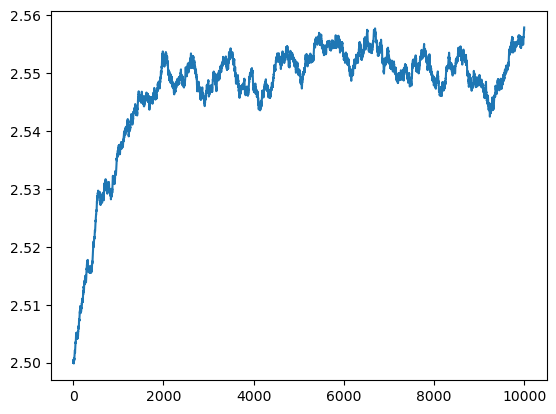

In [44]:
# Poisson model
plt.plot(np.mean(results_adj['w_mean'],axis=0))

To generate a raster like the one in Fig. 4: (there we used a slightly older figure with a different seed)

In [27]:
rng = np.random.default_rng(seed=0)
N_PFs = 120
pf_spike_rates = poisson_model_params['max_pf_rate']*np.ones((N_PFs, len(t_trial)))
pf_spikes = rng.random(size=pf_spike_rates.shape) < pf_spike_rates*dt_trial

(0.0, 120.0)

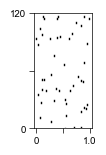

In [29]:
plt.figure(figsize=(0.75,1.5))
for i in range(N_PFs):
    for j in np.where(pf_spikes[i,:])[0]:
        plt.plot([t_trial[j],]*2, [i, i-0.9], c='k',lw=1)

plt.xticks(np.linspace(T_min_full, T_max_full, 3), [0, '', T_max_full-T_min_full])
plt.yticks([0, 60, 120],[0,'',120])
plt.ylim([0, N_PFs])
# plt.savefig('figures/poisson-basis-raster.pdf')

## Structured PF basis (same as OKR adaptation)

In [32]:
structured_model_params = {
    'max_pf_rate': 5,
    'pf_theta': 9,
    'cf_delay_fun': cf_delay_fun,
    'exc_current_kernel':np.exp(-(t_trial - t_trial[0])/10e-3),
    'type':'okr', #
    'peak_stim_vel': 10,
    'stim_f':1,
    'poisson_rate_equiv':0.5,
}

# These parameters were chosen so that over the course of a simulation, weights would equilibrate near baseline
plasticity_params_structured = {
    'dw_ltd': 3e-2,
    'dw_ltp': 3e-2*0.026,
    'decay_rate': 1/(1000)
}

In [41]:
results_adj = te_mp.simulateLearningAdjustment_TeMP(1, 10000, t_trial, cf_prob_fun, 
                               structured_model_params, plasticity_params_structured, 'multiple', tau, 
                               eligibility_params_sel, history_samples = 0,
                                calculate_hist = True, hist_every = 0,
                                PF_samples = [0, 60, 119],notebook_mode=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

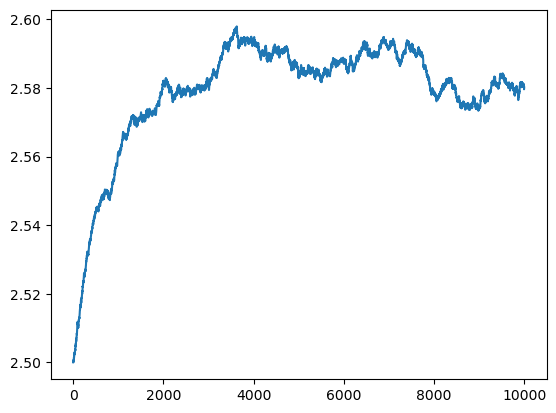

In [42]:
# Poisson model
plt.plot(np.mean(results_adj['w_mean'],axis=0))

In [34]:
rng = np.random.default_rng(seed=0)
N_PFs = 120
pf_spike_rates = te_mp.generatePFratesBasisOKR(t_trial, N_PFs= N_PFs, a=structured_model_params['max_pf_rate'], theta= structured_model_params['pf_theta'],
                                                peak_stim_vel = structured_model_params['peak_stim_vel'], stim_f = structured_model_params['stim_f'])
pf_spikes = rng.random(size=pf_spike_rates.shape) < pf_spike_rates*dt_trial

(0.0, 120.0)

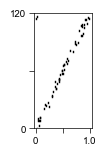

In [35]:
plt.figure(figsize=(0.75,1.5))
for i in range(N_PFs):
    for j in np.where(pf_spikes[i,:])[0]:
        plt.plot([t_trial[j],]*2, [i, i-0.9], c='k',lw=1)

plt.xticks(np.linspace(T_min_full, T_max_full, 3), [0, '', T_max_full-T_min_full])
plt.yticks([0, 60, 120],[0,'',120])
plt.ylim([0, N_PFs])
# plt.savefig('figures/learning-basis-raster.pdf')

# Analyze results — Poisson

In [10]:
# Results of running timer-selection-integrated.py for 10 simulation blocks
# of 1,000,000 trials, and a sample interval of 1,000 trials

folder = 'files/timer-selection-integrated-poisson' # Poisson basis
# folder = 'files/timer-selection-integrated-structured' # OKR adaptation basis

# mean weight
w_mean = np.load(folder+'/w_mean.npy')

# time of peak eligibility for 3 sample PFs through simulation
eligibility_history = np.load(folder+'/eligibility_window_history.npy')

# time of peak eligibility for all 120 PFs at the end of the simulation
v_final = np.load(folder+'/v.npy')

# time course of mean time of peak eligibility through simulation
eligibility_mean = np.load(folder+'/eligibility_window_mean.npy')

# histogram of PF-CF intervals for 3 sample PFs and (index 0) for all PFs,
# cumulatively over the simulation
hist_history_final = np.load(folder+'/hist_history.npy')

In [11]:
hist_edges = np.linspace(0, tau[-1] + (tau[1]-tau[0]), 100+1)

<BarContainer object of 100 artists>

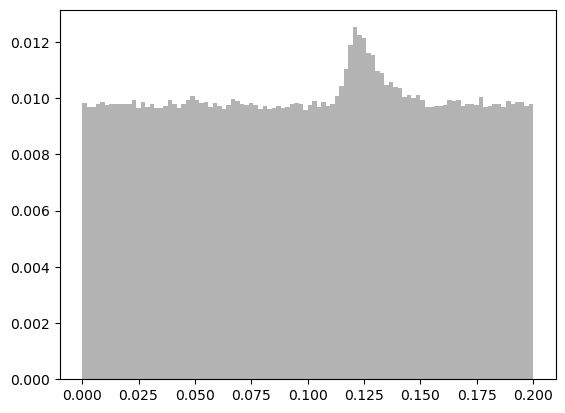

In [12]:
# for one of the sample PFs
pf_sample_ind = 1
plt.bar(hist_edges[:-1], hist_history_final[pf_sample_ind,:]/np.sum(hist_history_final[pf_sample_ind,:]), hist_edges[1],
        align='edge', facecolor=(0.7,)*3)

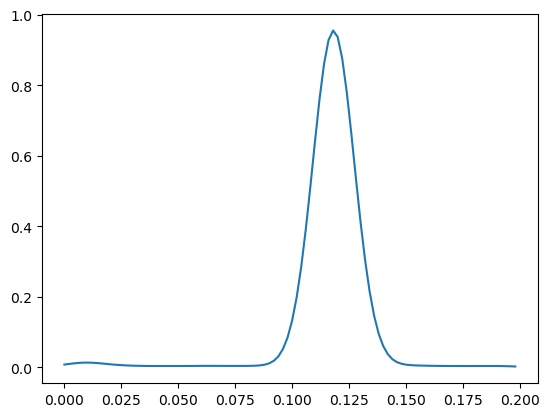

In [13]:
# Mean eligibility window after TeMP
plt.plot(tau, eligibility_mean[-1,:,-1])

## For Figure 4

(0.0, 1.0)

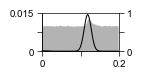

In [24]:
plt.figure(figsize=(1,0.5))

ax = plt.gca()

ax.fill_between(tau, hist_history_final[1,:]/np.sum(hist_history_final[1,:]), facecolor=(0.7,)*3)
ax.set_yticks(np.linspace(0, 0.015, 3))
ax.set_yticklabels([0,'',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([0, 0.2])
ax.set_ylim([0, 0.015])

ax2 = plt.twinx()
ax2.plot(tau, eligibility_mean[-1,:,-1],c='k',lw=0.75,clip_on=False)
ax2.set_yticks([0,0.5,1],[0,'',1])
ax2.set_ylim([0,1])


# plt.savefig('figures/multi-timer-integrated.pdf')

## For Figure S7

[Text(0.0, 0, '0'), Text(0.1, 0, ''), Text(0.2, 0, '0.2')]

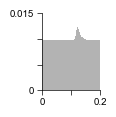

In [21]:
plt.figure(figsize=(0.75,1))

pf_sample_ind = 0 # 1, 2, 3 = example PFs, 0 = all PFs

plt.bar(hist_edges[:-1], hist_history_final[pf_sample_ind,:]/np.sum(hist_history_final[pf_sample_ind,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

# plt.savefig('figures/selection-integrated-hist-{:d}.pdf'.format(pf_sample_ind))